In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [16]:
df = pd.read_csv('train.csv')

In [17]:
# Remove irrelevant columns

In [18]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [19]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [20]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 0.5 * IQR_target
upper_bound_target = Q3_target + 0.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

In [21]:
# Check for missing values
df['reviews_per_month'].isna().sum()

1005

In [22]:
df['reviews_per_month'].describe()

count    4166.000000
mean        1.669671
std         2.006212
min         0.010000
25%         0.300000
50%         0.910000
75%         2.260000
max        19.900000
Name: reviews_per_month, dtype: float64

In [23]:
#reviews_per_month

# Split reviews_num into 3 equally-sized groups
df['reviews_per_month_group'] = pd.qcut(df['reviews_per_month'], q=7)
bin_intervals = df['reviews_per_month_group'].value_counts().sort_index().index
print(bin_intervals)

CategoricalIndex([(0.009000000000000001, 0.16],                 (0.16, 0.36],
                                  (0.36, 0.68],                 (0.68, 1.08],
                                   (1.08, 2.0],                  (2.0, 3.72],
                                  (3.72, 19.9]],
                 categories=[(0.009000000000000001, 0.16], (0.16, 0.36], (0.36, 0.68], (0.68, 1.08], (1.08, 2.0], (2.0, 3.72], (3.72, 19.9]], ordered=True, dtype='category')


In [25]:
# Bin reviews_per_month
bins = [-np.inf, 0.16, 0.37, 0.68, 1.08, 2, 3.69, 20, np.inf] #the above equally sized bin intervals are used as a proxy
labels = ['Rarely', 'Seldom', 'Occasionally', 'Sometimes', 'Regularly', 'Often','Mostly', 'no review']
df['reviews_per_month'] = pd.cut(df['reviews_per_month'], bins=bins, labels=labels)
df['reviews_per_month'] = df['reviews_per_month'].fillna('no review')

In [26]:
df['reviews_per_month'].dropna().unique()

['Sometimes', 'Mostly', 'Rarely', 'Often', 'Seldom', 'Occasionally', 'Regularly', 'no review']
Categories (8, object): ['Rarely' < 'Seldom' < 'Occasionally' < 'Sometimes' < 'Regularly' < 'Often' < 'Mostly' < 'no review']

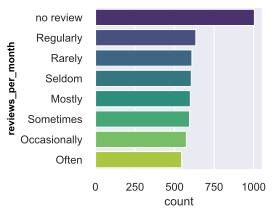

In [27]:
sns.set(style='darkgrid')
plt.figure(figsize=(3,3))
sns.countplot(y = df['reviews_per_month'],order = df['reviews_per_month'].value_counts().index,palette = "viridis")
plt.ylabel('reviews_per_month',fontsize = 10, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

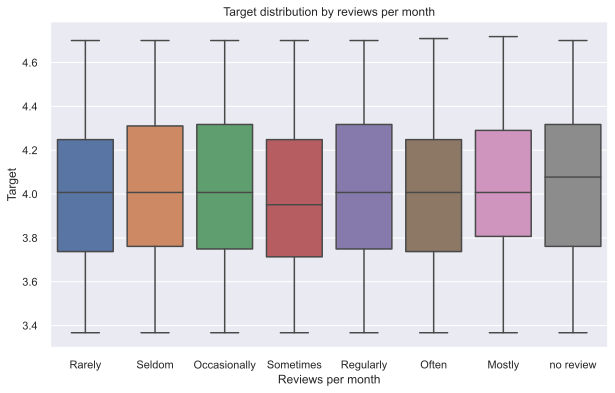

In [29]:
# Generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='reviews_per_month', y='target', data=df)
ax.set_title('Target distribution by reviews per month')
ax.set_xlabel('Reviews per month')
ax.set_ylabel('Target')
plt.show()

In [30]:
# Generate the statistical description
df.groupby('reviews_per_month')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
reviews_per_month,,,,,,,,
Rarely,610.0,4.008801,0.340057,3.367296,3.737670,4.007333,4.248495,4.700480
Seldom,606.0,4.012515,0.353256,3.367296,3.761200,4.007333,4.310731,4.700480
Occasionally,575.0,4.023617,0.350879,3.367296,3.749435,4.007333,4.317488,4.700480
Sometimes,595.0,3.995336,0.345726,3.367296,3.713572,3.951244,4.248495,4.700480
Regularly,635.0,4.027355,0.352387,3.367296,3.749435,4.007333,4.317488,4.700480
Often,545.0,4.004360,0.332263,3.367296,3.737670,4.007333,4.248495,4.709530
Mostly,600.0,4.028662,0.343059,3.367296,3.806662,4.007333,4.290459,4.718499
no review,1005.0,4.037661,0.355636,3.367296,3.761200,4.077537,4.317488,4.700480


In [31]:
# Check if there are significant differences in price between the types
from scipy.stats import f_oneway

policy_groups = [group['target'] for name, group in df.groupby('reviews_per_month')]
f_stat, p_value = f_oneway(*policy_groups)

if p_value < 0.05:
    print("There are significant differences in target values between types")
else:
    print("There are no significant differences in target values between types")

There are no significant differences in target values between types


In [32]:
# Because of the reasons highlighted in this EDA, we have decided to remove reviews_rating
# as an attribute from our training set.